# **Modelos de Inteligencia Artificial para Series Temporales**

## Probabilistic forecasting I: Temperature

- Anny Álvarez Nogales
- Paula Arias Fernández

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import aeon
#pip install utility_script_crps_score
#pip install statsmodels
#pip install aeon

In [50]:
def crps(submission, solution):
    """
    This routine returns the mean continuous ranked probability score (CRPS).
    Each individual CRPS score is numerically integrated using 23 points.
    The extremal points (100% coverage) are competition fixed at -30 and 60.
    The "submission" dataframe: the last 21 columns should be the predictions
    The "solution" dataframe must contain a "Temperature" column (the "ground truth")
    
    Author: Carl McBride Ellis
    Version: 1.0.0
    Date: 2024-03-30
    """
        
    # A list of the requested quantile values, along with added 100% coverage endpoints 
    # (these values are all competition fixed)
    # the 0.5 quantile is the "zero coverage" forecast i.e. the median point prediction
    quantiles = [0.00, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975, 1.00]
    submission_tmp = submission.copy()
    # inset the y_true values to the submission_tmp dataframe to the LHS
    submission_tmp.insert(0, "Temperature", solution["Temperature"].values)
    
    CRPS = 0
    for index, row in submission_tmp.iterrows():
        x_values = row[-(len(quantiles)-2):] # column name agnostic
        y_true = row["Temperature"] # the ground truth value
        
        x_values = [float(i) for i in x_values] # make sure all x values are floats
        # add extremal 100% quantile x-values so as to be sure to bracket all possible y_true values
        # note: any changing of these values will change the score
        x_values.append(-30.0)
        x_values.append( 60.0)
        x_values.sort() # sort x values into ascending order (no quantile crossing)

        # split predictions to the left and right of the true value
        # get items below the true value (y_true)
        LHS_keys = [i for i,x in enumerate(x_values) if x < y_true]
        # get items above the true value (y_true)
        RHS_keys = [i for i,x in enumerate(x_values) if x >= y_true]

        # quantiles and predictions below the true value (y_true)
        LHS_values = [x_values[i] for i in LHS_keys]
        LHS_quantiles = [quantiles[i] for i in LHS_keys]

        # quantiles and predictions above the true value (y_true)
        RHS_values = [x_values[i] for i in RHS_keys]
        RHS_quantiles = [quantiles[i] for i in RHS_keys]

        # also calculate quantile at y (q_at_y_true)
        x1, y1 = LHS_values[-1], LHS_quantiles[-1]
        x2, y2 = RHS_values[0], RHS_quantiles[0]
        q_at_y_true = ((y2-y1)*(y_true-x1)/(x2-x1))+y1

        # add y_true and q_at_y_true to RHS of LHS list
        LHS_values.append(y_true)
        LHS_quantiles.append(q_at_y_true)

        # add y_true and q_at_y_true to LHS of RHS list
        RHS_values.insert(0, y_true)
        RHS_quantiles.insert(0, q_at_y_true)

        # integrate the LHS as a sum of trapezium for CDF**2
        LHS_integral = 0
        for i in range(len(LHS_values)-1):
            LHS_integral += (0.5 * (LHS_values[i+1]-LHS_values[i]) * (LHS_quantiles[i]**2 + LHS_quantiles[i+1]**2) )

        # integrate the RHS as a sum of trapezium for (1-CDF)**2
        RHS_integral = 0
        for i in range(len(RHS_values)-1):
            RHS_integral += (0.5 * (RHS_values[i+1]-RHS_values[i]) * ((1-RHS_quantiles[i])**2 +(1-RHS_quantiles[i+1])**2 ) )

        CRPS += (LHS_integral + RHS_integral)

    del submission_tmp
    # calculate the mean CRPS
    CRPS = CRPS/len(submission)
    return CRPS


def coverage_report(submission, solution):
    """
    Version: 1.0.1
    """
    y_true = solution["Temperature"].values
    # this does not take the "zero coverage" prediction into account
    # which is assumed to be located in submission.csv column -11
    coverages = [95, 90, 80, 70, 60, 50, 40, 30, 20, 10]
    N = len(coverages)
    # ANSI color codes
    BOLD_RED = '\033[1;31m'
    BOLD_GREEN = '\033[1;32m'
    END_COLOR = '\033[0m'
    
    def mean_coverage(y_pred_low,y_true,y_pred_up):
        return ( (y_pred_low <= y_true) & (y_pred_up >= y_true) ).mean()
    
    for i, coverage in enumerate(coverages):
        lower_col, upper_col = (2*N+1-i), (i+1)
        actual_coverage = mean_coverage(submission.iloc[:,-lower_col], y_true, submission.iloc[:,-upper_col])
        actual_coverage = round(actual_coverage*100,2)
        if actual_coverage >= coverages[i]:
            print(BOLD_GREEN, "Ideal: {}% Actual: {}% [PASS]".format(coverage, actual_coverage), END_COLOR)
        else:
            print(BOLD_RED, "Ideal: {}% Actual: {}% [FAIL]".format(coverage, actual_coverage), END_COLOR)

# Carga de Datos

In [160]:
train_df = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])
test_df = pd.read_csv('test.csv', index_col='id', parse_dates=['date'])
train_df

,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
id,,,,,,,,
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
...,...,...,...,...,...,...,...,...
64315,2018-05-01 22:45:00,12.458,1.407,7.889,-0.746,4.843,1.523,10.622000
64316,2018-05-01 23:00:00,14.200,1.541,9.310,0.284,4.752,1.249,10.482000
64317,2018-05-01 23:15:00,12.659,1.474,7.924,-0.959,4.569,1.310,10.271000


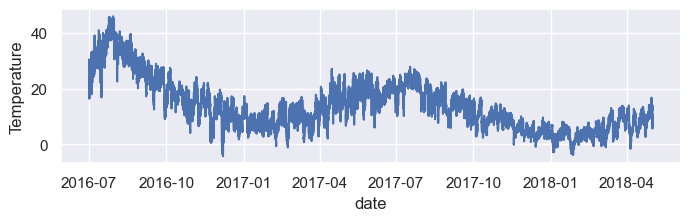

In [ ]:

fig, ax = plt.subplots(1,  1, figsize=(8, 2))
_ = sns.lineplot(train_df, x='date', y='Temperature', ax=ax)


# EDA

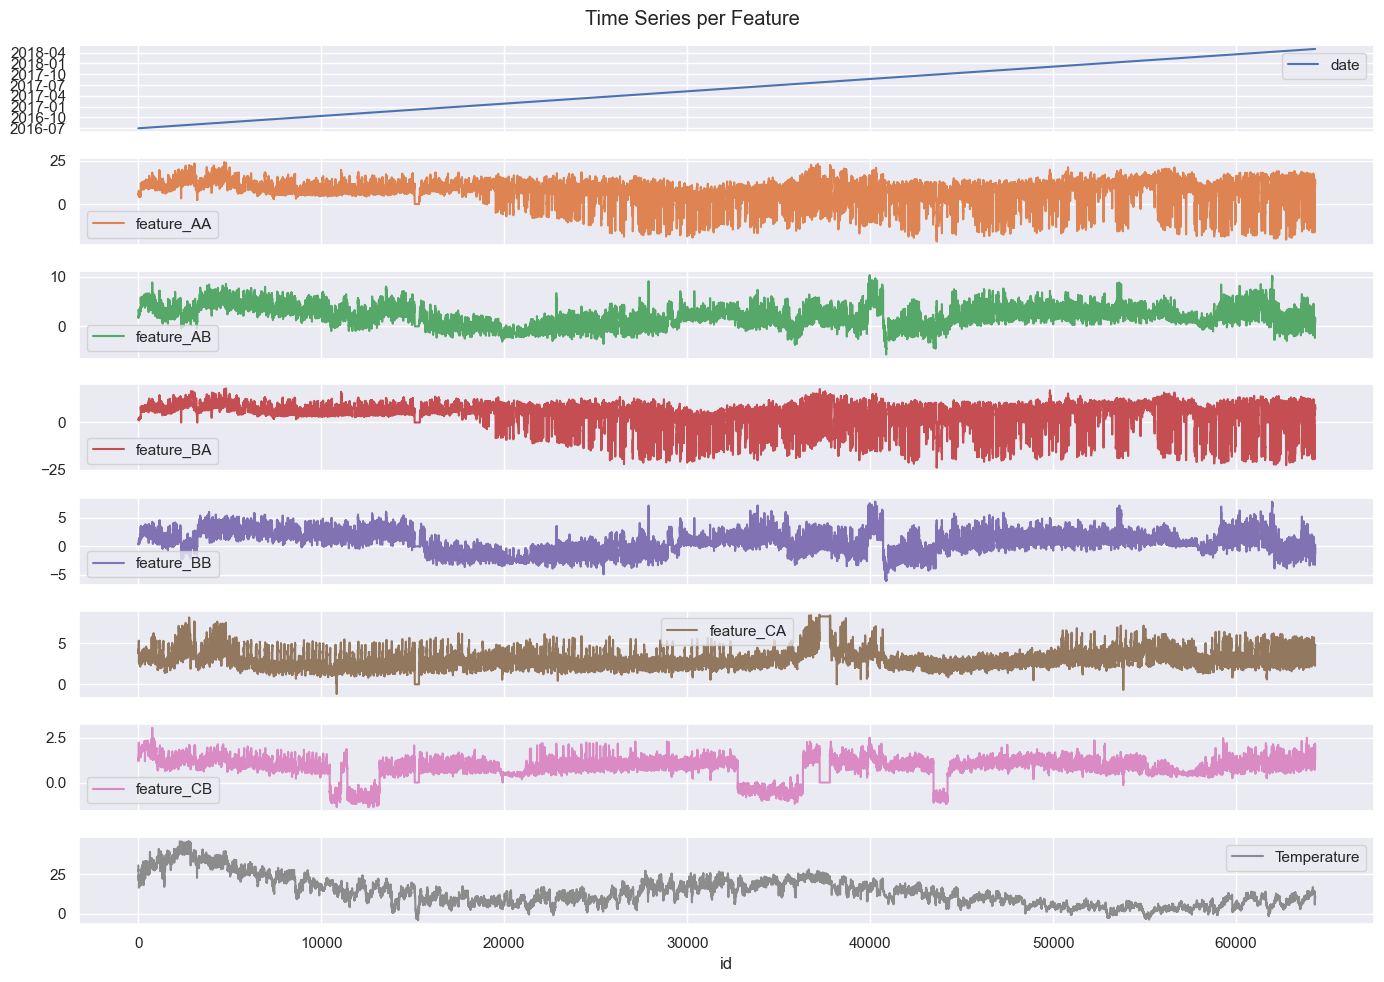

In [22]:
features = [col for col in train_df.columns if col not in ['id']]
train_df[features].plot(subplots=True, figsize=(14, 10), title="Time Series per Feature")
plt.tight_layout()
plt.show()


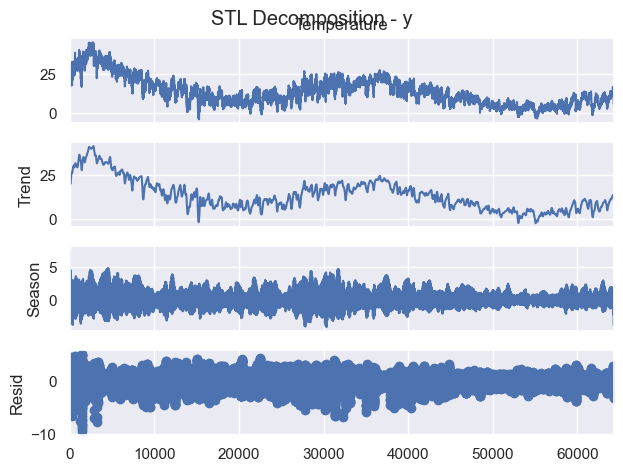

In [23]:
### Estacionariedad, estacionalidad

from statsmodels.tsa.seasonal import STL

result = STL(train_df['Temperature'], period=96).fit()
result.plot()
plt.suptitle("STL Decomposition - y")
plt.show()



In [24]:
from statsmodels.tsa.stattools import adfuller

for col in features:
    result = adfuller(train_df[col].dropna())
    print(f"{col}: p-value = {result[1]:.4f} {'✅ Stationary' if result[1] < 0.05 else '❌ Not stationary'}")


date: p-value = 0.0000 ✅ Stationary
feature_AA: p-value = 0.0000 ✅ Stationary
feature_AB: p-value = 0.0000 ✅ Stationary
feature_BA: p-value = 0.0000 ✅ Stationary
feature_BB: p-value = 0.0000 ✅ Stationary
feature_CA: p-value = 0.0000 ✅ Stationary
feature_CB: p-value = 0.0000 ✅ Stationary
Temperature: p-value = 0.0012 ✅ Stationary


Missing values:
 date           0
feature_AA     0
feature_AB     0
feature_BA     0
feature_BB     0
feature_CA     0
feature_CB     0
Temperature    0
dtype: int64


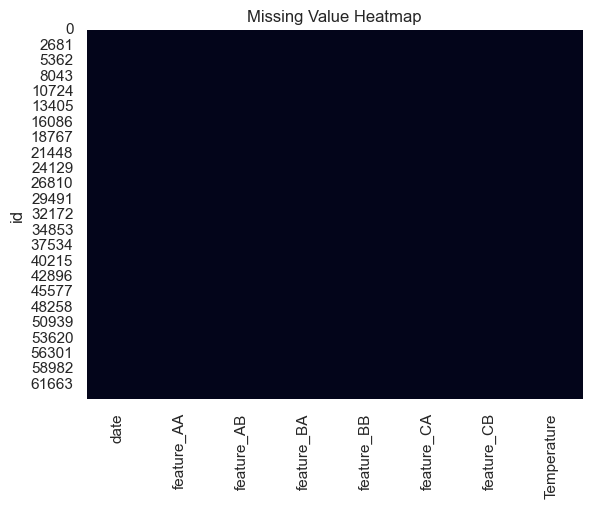

In [26]:
### Valores nulos, anomalías
print("Missing values:\n", train_df.isnull().sum())

# Optional: visualize missingness
sns.heatmap(train_df.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()


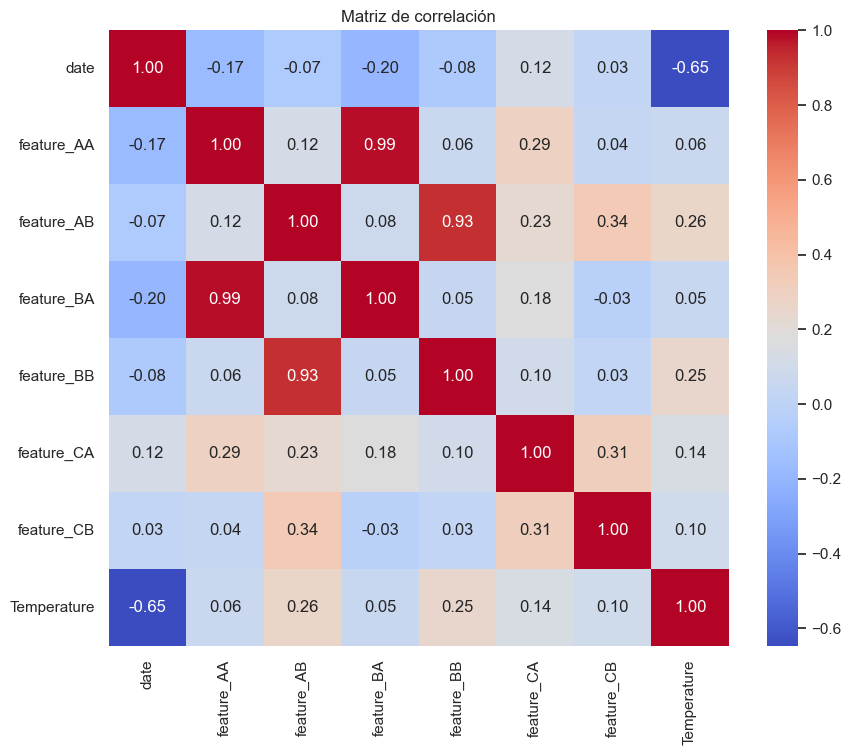

In [27]:
### Correlación
corr_matrix = train_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()


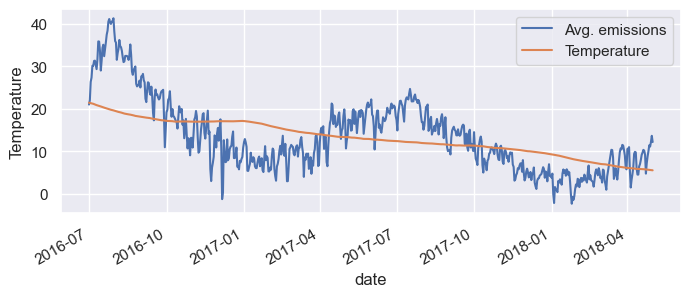

In [28]:
# daily data
daily_temp = (
    train_df[['date', 'Temperature']]
    .set_index('date')
    .resample('D')
    .mean() 
    .reset_index()
)
# compute the yearly moving average
moving_average = daily_temp.set_index('date').rolling(
    window=365,       
    center=True,      
    min_periods=183,
).mean()     


fig,ax =plt.subplots(1,1,figsize=(8, 3))
_ = sns.lineplot(daily_temp, x='date',y='Temperature',ax=ax,label='Avg. emissions')

_ = moving_average.plot(ax=ax,label='Moving average')
_ = ax.legend(loc='best')

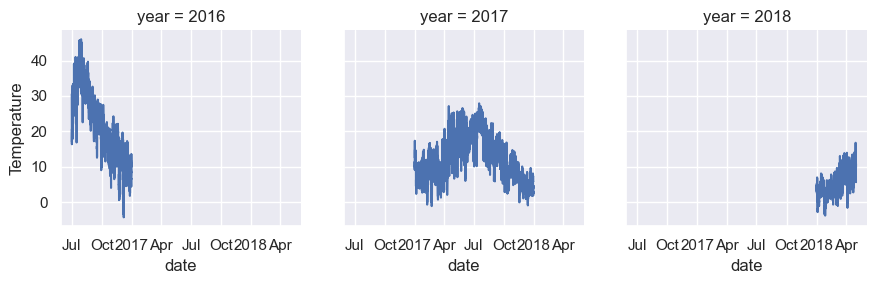

In [30]:
import matplotlib.dates as mdates

# Calculate average 'y' values per month across all years
train_df_plot = train_df.copy()
train_df_plot['year'] = train_df_plot['date'].dt.year

g = sns.FacetGrid(train_df_plot, col="year")
g.map(sns.lineplot, "date", "Temperature")
g.axes[0,0].xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

[Text(0.5, 0, 'Month')]

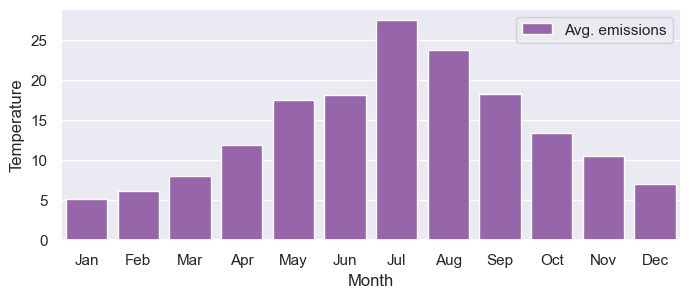

In [31]:
monthly_avg = train_df.groupby(train_df['date'].dt.month)['Temperature'].mean().reset_index()

# Create a mapping for month numbers to month names for better readability in the plot
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
monthly_avg['date'] = monthly_avg['date'].apply(lambda x: month_names[x])

fig,ax =plt.subplots(1,1,figsize=(8, 3))
_ = sns.barplot(monthly_avg, x='date',y='Temperature', ax=ax,label='Avg. emissions', color="#9b59b6")
ax.set(xlabel='Month')


# Modelos

In [ ]:
#ideas
# random forest, naive, prophet, arima, sarima
# hacer aumento de datos
# dividir datos en intervalos diferentes (ahora son 15 minutos, se puede agrupar en horas)
#de momento se usan todos los datos para entrenar 
#aunque se pueden usar para train y val los de train y predecir con test

### Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor

train_X = train_df[[feature for feature in train_df.columns if feature.startswith("feature")]]
train_y = train_df["Temperature"]

test_X = test_df[[feature for feature in test_df.columns if feature.startswith("feature")]]
test_X

model = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
model.fit(train_X, train_y)

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

In [38]:
pred_y = [est.predict(test_X.values) for est in model.estimators_]
proba_preds = np.array(pred_y)


In [43]:
quantiles = [0.025,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975]
print(quantiles, len(quantiles))

quantile_predictions = {"index": test_df.index.values}
quantile_predictions.update({q: None for q in quantiles})
for q in quantiles:
    quantile_predictions[q] = np.quantile(proba_preds, q, axis=0)
submission_df = pd.DataFrame.from_dict(quantile_predictions)
submission_df

[0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975] 21


,index,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975
0,64320,4.573000,4.64300,5.0650,5.135,5.135,5.135,5.4870,6.050000,6.753000,...,8.020000,8.512000,9.567000,10.271000,13.366000,17.445999,20.823000,21.878000,38.269001,39.887001
1,64321,2.949725,4.92400,6.2610,6.894,7.175,7.457,7.8790,7.924500,8.090000,...,8.934000,9.314000,9.989000,10.200000,11.537000,15.125000,16.672001,34.400002,36.580002,42.278999
2,64322,4.854000,4.85400,5.0650,6.613,7.513,8.512,8.8640,9.426000,9.426000,...,9.426000,9.426000,9.426000,9.567000,9.989000,10.130000,10.130000,10.904000,15.125000,23.231976
3,64323,2.603000,4.63245,5.2549,5.276,7.527,9.426,9.7570,10.904000,12.100000,...,12.733000,16.882999,21.525999,31.797001,34.891998,35.174000,37.776001,38.832001,40.167999,42.649351
4,64324,5.065000,5.20600,5.6280,7.457,7.457,7.668,8.5120,8.723000,9.426000,...,17.165001,17.165001,17.165001,17.165001,17.868000,17.868000,39.345151,43.756001,44.952000,44.952000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,69675,2.040000,2.04000,2.6030,2.955,3.025,3.588,3.7280,4.502000,5.135000,...,7.161450,7.949000,8.020000,10.503000,14.140000,16.954000,20.211000,21.385000,22.299999,23.566000
5356,69676,2.040000,2.72640,2.7440,2.884,2.884,2.955,3.1660,3.397650,3.728000,...,8.864000,13.296000,14.709700,19.437000,21.174000,22.089001,30.129999,31.375000,35.455002,39.042999
5357,69677,2.744000,3.16245,3.8690,5.487,6.050,6.472,10.1300,11.744150,13.296000,...,19.979000,22.089001,24.663550,29.546000,31.375000,32.360001,35.103001,37.354000,39.535000,40.176799
5358,69678,3.377000,4.43200,4.4320,4.432,4.643,4.995,6.0077,9.708000,16.954000,...,19.275000,19.344999,19.486000,19.760301,25.888000,29.095200,30.882000,31.375000,33.695999,34.119775


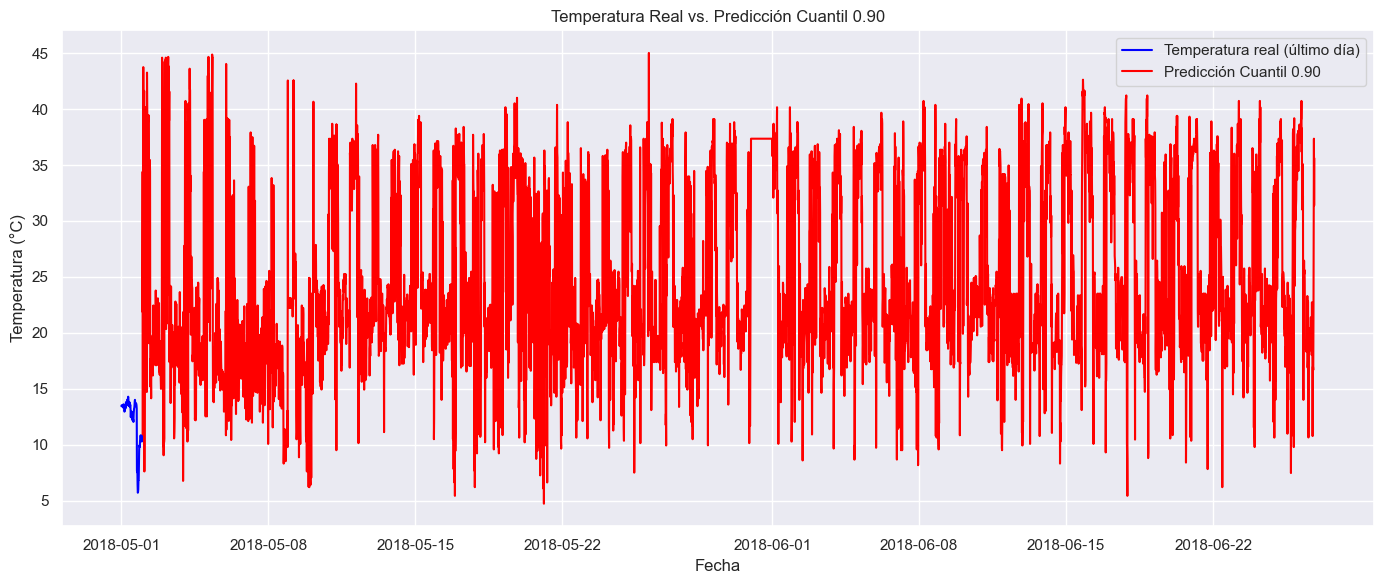

In [145]:
import matplotlib.pyplot as plt
import pandas as pd

# Extrae la cola de train_df
train_tail = train_df['Temperature'].iloc[-96:]  # Último día

# Generar índice temporal para test (asumiendo misma frecuencia)
test_start = train_tail.index[-1] + pd.Timedelta(minutes=15)
test_index = pd.date_range(start=test_start, periods=len(submission_df), freq='15T')

# Tomar solo cuantil 0.90 y asignar fechas
quantile_90 = submission_df[0.90].copy()
quantile_90.index = test_index

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(train_tail.index, train_tail.values, label='Temperatura real (último día)', color='blue')
plt.plot(quantile_90.index, quantile_90.values, label='Predicción Cuantil 0.90', color='red')

plt.title('Temperatura Real vs. Predicción Cuantil 0.90')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Naive forecast (FAIL)


In [173]:
import numpy as np
import pandas as pd
from aeon.forecasting.naive import NaiveForecaster
from aeon.forecasting.base import ForecastingHorizon

# 1) Prepara la Serie y con índice datetime y freq
#y = train_df['Temperature'].copy()
#y.index = pd.to_datetime(train_df['date'])
#y = y.asfreq('15T')  # asegúrate de la frecuencia

# 2) Define horizonte de pronóstico
fh = ForecastingHorizon(np.arange(1, len(test_df) + 1), is_relative=True)

# 3) Bootstrap manual: muestreamos valores, pero guardamos el índice original
n_estimators = 100
boot_preds = []

for i in range(n_estimators):
    # a) generamos índices aleatorios
    idx = np.random.RandomState(i).choice(len(y), size=len(y), replace=True)
    # b) muestreamos los valores
    y_boot_values = y.values[idx]
    # c) reconstruimos la Serie con el índice original
    y_boot = pd.Series(y_boot_values, index=y.index)
    
    # d) entrenamos el NaiveForecaster
    forecaster = NaiveForecaster(strategy="last", sp=96, window_length=96)
    forecaster.fit(y_boot)
    
    # e) predecimos en el horizonte fh
    preds = forecaster.predict(fh)
    boot_preds.append(preds.values)

# 4) agregamos en un array (n_estimators, n_test)
proba_preds = np.vstack(boot_preds)

# 5) calculamos los cuantiles
quantiles = [0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30,
             0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65,
             0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975]

quantile_predictions = {"index": test_df.index.values}
for q in quantiles:
    quantile_predictions[q] = np.quantile(proba_preds, q, axis=0)

submission_df = pd.DataFrame.from_dict(quantile_predictions)



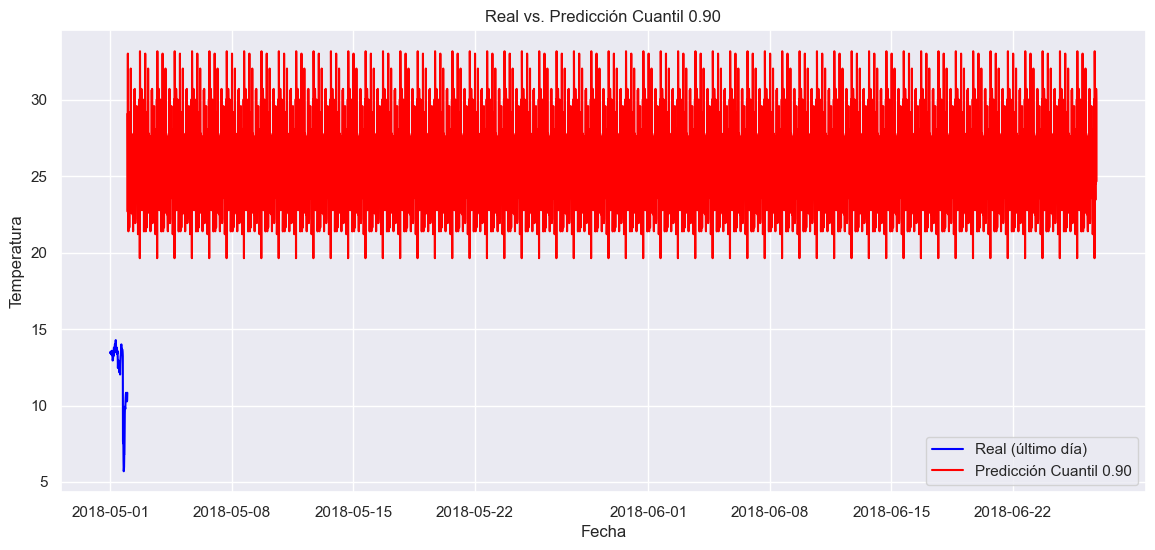

In [174]:

# 6) visualizar solo el cuantil 0.90 junto al tail de train_df
import matplotlib.pyplot as plt

# cola real
#train_df['date'] = pd.to_datetime(train_df['date'])
#train_df.set_index('date', inplace=True)
train_df = train_df.asfreq('15T')
train_tail = train_df['Temperature'].iloc[-96:]  # último día

# índice de test con fecha
start = train_tail.index[-1] + pd.Timedelta(minutes=15)
test_index = pd.date_range(start, periods=len(test_df), freq='15T')

q90 = submission_df[0.90].copy()
q90.index = test_index

plt.figure(figsize=(14, 6))
plt.plot(train_tail.index, train_tail.values, label='Real (último día)', c='blue')
plt.plot(q90.index, q90.values, label='Predicción Cuantil 0.90', c='red')
plt.title('Real vs. Predicción Cuantil 0.90')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.show()

########FAIL
tutorial seguido: https://www.aeon-toolkit.org/en/v0.6.0/examples/forecasting/forecasting.html

In [ ]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.set_index('date', inplace=True)

In [151]:
train_size = int(len(train_df) * 0.8)
train_data = train_df


In [155]:
from aeon.forecasting.naive import NaiveForecaster
train_df = train_df.asfreq('15T') 

forecaster = NaiveForecaster(strategy="mean",sp=12,window_length=12)
forecaster.fit(train_data['Temperature'])


NaiveForecaster(sp=12, strategy='mean', window_length=12)

In [ ]:
test_df['date'] = pd.to_datetime(test_df['date'])
test_df.set_index('date', inplace=True)


In [ ]:
fh = np.arange(1, len(test_df) + 1)  # horizonte de pronóstico
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

y_pred_quantiles_test = forecaster.predict_quantiles(alpha=alpha_values, fh=fh)
y_pred_quantiles_test

In [142]:
train_df = train_df.asfreq('15T') 
test_start = train_df.index[-1] + pd.Timedelta(minutes=15)
num_preds = len(y_pred_quantiles_test)
test_dates = pd.date_range(start=test_start, periods=num_preds, freq='15T')

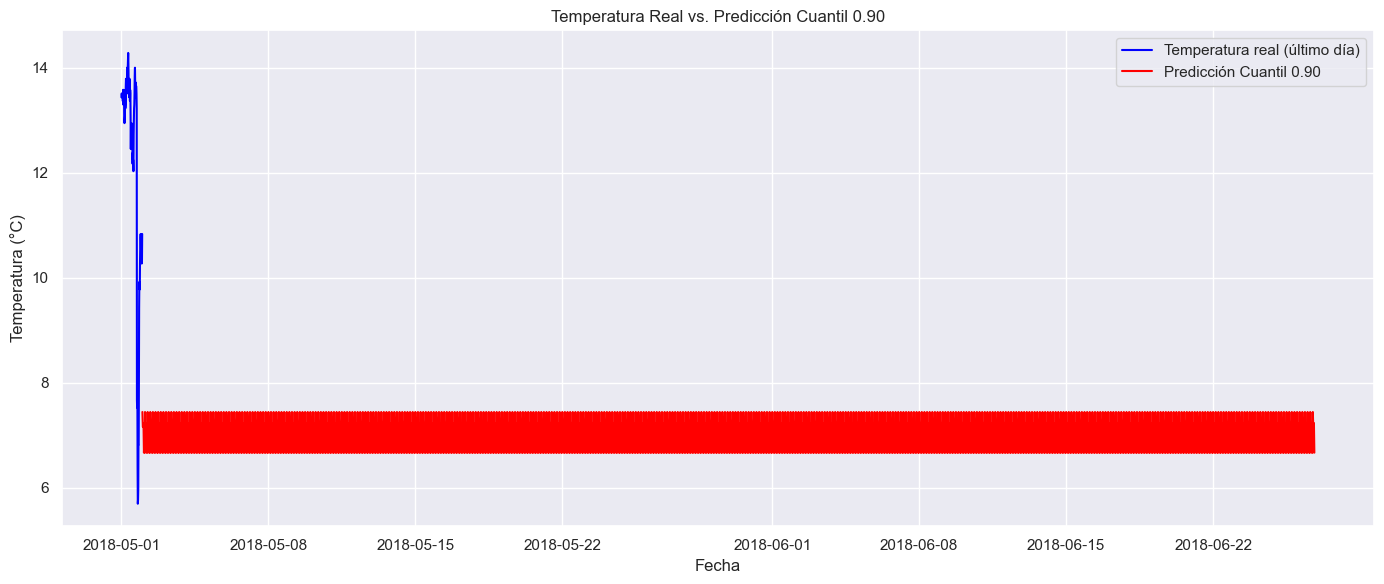

In [144]:
# Extraer solo el cuantil 0.90
quantile_90 = y_pred_quantiles_test[('Quantiles', 0.8)].copy()
quantile_90.index = test_dates
import matplotlib.pyplot as plt

# Tomar la cola de los datos reales para comparación
train_tail = train_df['Temperature'].iloc[-96:]  # 1 día = 96 pasos de 15 minutos

plt.figure(figsize=(14, 6))
plt.plot(train_tail.index, train_tail.values, label='Temperatura real (último día)', color='blue')
plt.plot(quantile_90.index, quantile_90.values, label='Predicción Cuantil 0.90', color='red')

plt.title('Temperatura Real vs. Predicción Cuantil 0.90')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
